# Converting a pdf to text with pdftotext

Source: https://github.com/jalan/pdftotext

`pdftotext` needs to be installed first. Run the `install-pdftotext.sh` script in the parent directory to install it.

In [1]:
import pdftotext

Read the file and convert to text.

In [2]:
with open('../data/Exhibit-A-SAMPLE-CONTRACT.pdf', 'rb') as f:
    pdf = pdftotext.PDF(f)

In [3]:
type(pdf)

pdftotext.PDF

A `pdftotext.PDF` object works like a list of strings, each of which corresponds to a page of the document.

Number of pages.

In [4]:
len(pdf)

11

Print one page.

In [5]:
print(pdf[0])

                                 Exhibit A – Sample Contract
SAMPLE CONTRACT
     OFFICE OF HAWAIIAN AFFAIRS
      CONTRACT NUMBER ________
        REQUEST FOR PROPOSALS
    PURCHASE OF GOODS AND SERVICES
          CONTRACT BETWEEN
      OFFICE OF HAWAIIAN AFFAIRS
                 AND
         XXXXXXXXXX



## Text vectorization

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [7]:
tf_vectorizer = TfidfVectorizer(
    stop_words='english',
    max_df=0.95,
    min_df=2,
    use_idf=False,
    ngram_range=(1,1),
    max_features=5000
)
tf_vectors = tf_vectorizer.fit_transform(pdf)

In [8]:
tf_vectors.shape

(11, 121)

In [9]:
tf_vectorizer.get_feature_names()

['10',
 '100',
 '12',
 '2016',
 '712',
 '________',
 '_______________________________________',
 'accordance',
 'act',
 'actual',
 'address',
 'affairs',
 'agreement',
 'approval',
 'approved',
 'attached',
 'attachment',
 'availability',
 'behalf',
 'blank',
 'business',
 'ceo',
 'chief',
 'compensation',
 'conditions',
 'conduct',
 'contractor',
 'control',
 'coordinator',
 'corporate',
 'currently',
 'date',
 'days',
 'declaration',
 'deliverables',
 'described',
 'description',
 'determined',
 'document',
 'dollar',
 'dollars',
 'excise',
 'executed',
 'executive',
 'extensions',
 'follows',
 'forth',
 'funds',
 'general',
 'goods',
 'hawai',
 'hawaii',
 'hawaiian',
 'hereto',
 'honolulu',
 'including',
 'intentionally',
 'ka',
 'left',
 'location',
 'mailing',
 'manner',
 'maximum',
 'months',
 'number',
 'office',
 'officer',
 'oha',
 'page',
 'parties',
 'payment',
 'percent',
 'perform',
 'performance',
 'performed',
 'period',
 'person',
 'personally',
 'ph',
 'pouhana',
 'pri

## Dimensional reduction and plotting

In [10]:
from sklearn.decomposition import TruncatedSVD
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [11]:
tsvd = TruncatedSVD(n_components=2)

In [12]:
X_red = tsvd.fit_transform(tf_vectors)

In [13]:
X_red.shape

(11, 2)

In [14]:
trace = go.Scatter(
    x = X_red[:,0],
    y = X_red[:,1],
    mode='markers'
)

data = [trace]

fig = go.Figure(data=data)

iplot(fig)

## LDA for topic analysis

In [15]:
lda = LatentDirichletAllocation(
    n_components=5,
    max_iter=20,
    random_state=42,
    learning_method='batch'
)

lda_vectors = lda.fit_transform(tf_vectors)

In [16]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_words = " ".join(
            [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        )
        print("Topic #{}: {}".format(topic_idx, top_words))
    print()

In [17]:
print_top_words(lda, tf_vectorizer.get_feature_names(), 3)

Topic #0: hawaiian affairs office
Topic #1: contractor oha shall
Topic #2: ________ goods proposals
Topic #3: ________ goods proposals
Topic #4: ________ goods proposals



## Word embedding with `GloVe` from `spacy`

In [18]:
import sys
sys.path.insert(0, '../src/')
import pdf_lda
import os
import spacy
import numpy as np
from umap import UMAP
import pickle

Read one of the pdf files in the data folder.

In [19]:
DATA_DIR = '../data/'

In [20]:
os.listdir(DATA_DIR)

['example_02.png',
 'samplecontract.pdf',
 'cleaning-contract-template-image.jpg',
 'ProfessionalServiceContract.pdf',
 'long_contract_2d_vectors.pkl',
 'example_03.png',
 'Exhibit-A-SAMPLE-CONTRACT.pdf',
 'example_01.png']

In [21]:
filename = os.listdir(DATA_DIR)[-2]

if filename.split('.')[-1]=='pdf':
    with open(os.path.join(DATA_DIR, filename), 'rb') as f:
        pdf = pdftotext.PDF(f)
else:
    print("Please use a pdf file")

In [22]:
text = ''.join(pdf)

In [23]:
nlp = spacy.load('en_core_web_lg') 

In [26]:
nlp(text)

                                 Exhibit A – Sample Contract
SAMPLE CONTRACT
     OFFICE OF HAWAIIAN AFFAIRS
      CONTRACT NUMBER ________
        REQUEST FOR PROPOSALS
    PURCHASE OF GOODS AND SERVICES
          CONTRACT BETWEEN
      OFFICE OF HAWAIIAN AFFAIRS
                 AND
         XXXXXXXXXX
                                                                        Exhibit A – Sample Contract
        This Contract, executed as of this ______day of _________, 201__, by and between, the
Office of Hawaiian Affairs (“OHA”), a body corporate under the Constitution of State of
Hawai‘i, by its Ka Pouhana, Chief Executive Officer (“CEO”) , acting by and on behalf of the
Board of Trustees, whose principal place of business and mailing address is 560 North Nimitz
Highway, Suite 200, Honolulu, Hawai‘i 96817, and [NAME OF CONTRACTOR]
(“CONTRACTOR”), a Hawaii‘ corporation, by its President, whose principal place of business
and mailing address is [XXXXXX], Honolulu, Hawai‘i 96[XXX], Feder

In [ ]:
nlp(text)

In [87]:
glove_vectors = np.concatenate(
    [nlp(token.text).vector.reshape(1,300) for token in nlp(text)]
)

In [28]:
doc = nlp(text)

In [159]:
pos_to_ignore = [
    'ADP',
    'AUX',
    'CONJ',
    'CCONJ',
    'DET',
    'INTJ',
    'NUM',
    'PART',
    'PRON',
    'PROPN',
    'PUNCT',
    'SCONJ',
    'SYM',
    'SPACE',
    'X'
]

pos_to_keep = ['NOUN']

text_to_ignore = ['-', '_', '”', '–']

In [172]:
tokens = {token for token in doc if token.pos_ in pos_to_keep}

words = list({token.lemma_ for token in tokens if token.text not in text_to_ignore})

words

['convention',
 'employment',
 'violation',
 'hrs',
 'no',
 'statue',
 'penalty',
 'expense',
 'profit',
 'fund',
 'certification',
 'justice',
 'year',
 'extension',
 '#',
 'decision',
 'party',
 'time',
 'print',
 'gift',
 'hour',
 'proposal',
 'case',
 'member',
 'length',
 'compensation',
 'matter',
 'wherea',
 'option',
 'committee',
 'section',
 'business',
 'address',
 'position',
 'debt',
 'legislator',
 'fact',
 'monitor',
 'postage',
 'security',
 'reconciliation',
 'deed',
 'officer',
 'review',
 'companion',
 'b',
 'receipt',
 'contractor',
 'corporation',
 'act',
 'deliverable',
 'reference',
 'period',
 'lieu',
 'ceo',
 'description',
 's',
 'event',
 'document',
 'view',
 'agreement',
 'statement',
 'law(s',
 'source',
 'body',
 'commission',
 'vendor',
 'copy',
 'n',
 'place',
 'employee',
 'manner',
 'e',
 'h',
 'email',
 'work',
 's1',
 'declaration',
 'delegate',
 'part',
 'need',
 'award',
 'condition',
 'presentment',
 'conflict',
 'schedule',
 'development',
 'pol

In [164]:
glove_vectors = np.concatenate(
    [nlp(word).vector.reshape(1,300) for word in words]
)
glove_vectors.shape

(179, 300)

In [165]:
umapper = UMAP(n_neighbors=25)

In [166]:
umap_vectors = umapper.fit_transform(glove_vectors)

In [167]:
umap_vectors.shape

(179, 2)

In [168]:
import matplotlib.pyplot as plt

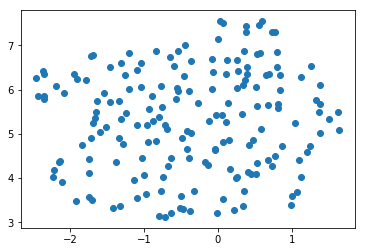

In [169]:
plt.scatter(
    x=umap_vectors[:,0],
    y=umap_vectors[:,1]
)
plt.show()

In [170]:
words = [token.text for token in tokens]

In [174]:
# with open('../data/long_contract_2d_vectors.pkl', 'wb') as f:
#     pickle.dump(umap_vectors, f)

# with open('../data/long_contract_words.pkl', 'wb') as f:
#     pickle.dump(words, f)

In [173]:
trace = go.Scatter(
    x = umap_vectors[:,0],
    y = umap_vectors[:,1],
    mode = 'markers',
    text = words
)

layout = go.Layout(
    hovermode = 'closest'
)

data = [trace]

fig = go.Figure(data=data)

iplot(fig)